In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 10.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
# Pytorch package
import torch
import torch.nn as nn
from torchmetrics.regression import MeanAbsolutePercentageError

In [ ]:
df = pd.read_csv("cgm_data.csv")
for column in df.columns:
    df[column] = df[column].astype(float)
df.rename({0:"ID"}, axis=1)
df = df.drop("ptid", axis=1)
df = df.iloc[:-1 , :]

In [ ]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [ ]:
# Define constants
N_EPOCHS = 250
NHEAD = 1
NHID = 64
NLAYERS = 2
LR = 0.01
training_patients = 20
EMBED_DIM=4
prediction_horizon = 1

In [ ]:
class PositionalEncoding(nn.Module): # from https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 500, device='cuda'):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model).to(device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
# Define the transformer model
class TransformerModel(nn.Module):
    def __init__(self, embed_dim, nhead, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Embedding(500, embed_dim, device = 'cuda')
        self.pos_encoder = PositionalEncoding(d_model = embed_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_dim, nhead, dim_feedforward), num_layers)

        self.linear = nn.Linear(embed_dim, 1)

        self.mask_dict={}
        for i in range(480):
            self.mask_dict[i] = self.generate_square_subsequent_mask(i)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz,device=device)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        mask = self.mask_dict[x.size(0)]
        x = x.type(torch.LongTensor).to(device)
        x = self.embedding(x)
        x = x.squeeze(2)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x,)# mask)
        x = self.linear(x)
        return x

# Function to split the data
def train_test_split(df, training_patients, prediction_horizon, device):
    train_input = torch.from_numpy(df.iloc[:training_patients,:-prediction_horizon].values).float().to(device)
    train_target = torch.from_numpy(df.iloc[:training_patients, prediction_horizon:].values).float().to(device)
    test_input = torch.from_numpy(df.iloc[training_patients:,:-prediction_horizon].values).float().to(device)
    test_target = torch.from_numpy(df.iloc[training_patients:, prediction_horizon:].values).float().to(device)

    train_input = torch.unsqueeze(train_input, -1).permute(1, 0, 2)
    train_target = torch.unsqueeze(train_target, -1).permute(1, 0, 2)
    test_input = torch.unsqueeze(test_input, -1).permute(1, 0, 2)
    test_target = torch.unsqueeze(test_target, -1).permute(1, 0, 2)
    return train_input, train_target, test_input, test_target

In [ ]:
train_input, train_target, test_input, test_target = train_test_split(df, training_patients, prediction_horizon, device)
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

# Initialize the model
model = TransformerModel(embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NLAYERS, dim_feedforward=NHID).to(device)
criterion = MeanAbsolutePercentageError().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
test_losses = []
avg_test_losses = []


for epoch in tqdm(range(N_EPOCHS)):
    model.train()
    for t in range(0, train_input.shape[0]):
        for patient in range(training_patients):# Loop over the time steps in each epoch
            optimizer.zero_grad()
            output = model(train_input[:t+1,patient,:])
            if len(output.shape) < 3:
                output = output.unsqueeze(0)
            loss = criterion(output, train_target[:t+1,patient,:].unsqueeze(2))
            loss.backward()
            optimizer.step()
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'At epoch {epoch}, Training Loss {loss.item()}')


    model.eval()

    with torch.no_grad():
        test_losses = []  # Collect test losses at each time step
        for t in range(0, test_input.shape[0]):
            test_output = model(test_input[:t+1,:,:])
            test_loss = criterion(test_output, test_target[:t+1,:,:])
            test_losses.append(test_loss.item())
        avg_test_loss = np.mean(test_losses)
        avg_test_losses.append(avg_test_loss)

    if epoch % 10 == 0:
        print(f'Test Loss at epoch {epoch} is {avg_test_loss}')


torch.Size([479, 20, 1])
torch.Size([479, 20, 1])
torch.Size([479, 76, 1])
torch.Size([479, 76, 1])


  0%|          | 0/250 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.05980769917368889


  0%|          | 1/250 [00:55<3:49:44, 55.36s/it]

Test Loss at epoch 0 is 0.07222389866887652


  4%|▍         | 10/250 [09:23<3:46:01, 56.50s/it]

At epoch 10, Training Loss 0.050127387046813965


  4%|▍         | 11/250 [10:19<3:45:02, 56.50s/it]

Test Loss at epoch 10 is 0.06277305454731237


  8%|▊         | 20/250 [18:48<3:36:47, 56.55s/it]

At epoch 20, Training Loss 0.049233440309762955


  8%|▊         | 21/250 [19:45<3:36:04, 56.61s/it]

Test Loss at epoch 20 is 0.062325797329553734


 12%|█▏        | 30/250 [28:13<3:27:06, 56.48s/it]

At epoch 30, Training Loss 0.06289763748645782


 12%|█▏        | 31/250 [29:10<3:26:28, 56.57s/it]

Test Loss at epoch 30 is 0.06887851072969167


 16%|█▌        | 40/250 [37:39<3:17:56, 56.55s/it]

At epoch 40, Training Loss 0.04979042336344719


 16%|█▋        | 41/250 [38:36<3:17:01, 56.56s/it]

Test Loss at epoch 40 is 0.061642114423013185


 20%|██        | 50/250 [47:05<3:08:34, 56.57s/it]

At epoch 50, Training Loss 0.050339486449956894


 20%|██        | 51/250 [48:02<3:07:36, 56.57s/it]

Test Loss at epoch 50 is 0.06166296868365344


 24%|██▍       | 60/250 [56:30<2:58:53, 56.49s/it]

At epoch 60, Training Loss 0.04955967888236046


 24%|██▍       | 61/250 [57:27<2:58:10, 56.56s/it]

Test Loss at epoch 60 is 0.06191642437760168


 28%|██▊       | 70/250 [1:05:55<2:49:26, 56.48s/it]

At epoch 70, Training Loss 0.049360185861587524


 28%|██▊       | 71/250 [1:06:52<2:48:29, 56.48s/it]

Test Loss at epoch 70 is 0.061244353022045284


 32%|███▏      | 80/250 [1:15:20<2:40:25, 56.62s/it]

At epoch 80, Training Loss 0.049568381160497665


 32%|███▏      | 81/250 [1:16:17<2:39:35, 56.66s/it]

Test Loss at epoch 80 is 0.06272820735618566


 36%|███▌      | 90/250 [1:24:46<2:30:52, 56.58s/it]

At epoch 90, Training Loss 0.04944844916462898


 36%|███▋      | 91/250 [1:25:42<2:29:52, 56.56s/it]

Test Loss at epoch 90 is 0.06246163713938259


 40%|████      | 100/250 [1:34:13<2:22:00, 56.80s/it]

At epoch 100, Training Loss 0.04966074600815773


 40%|████      | 101/250 [1:35:10<2:21:05, 56.82s/it]

Test Loss at epoch 100 is 0.06113584625820526


 44%|████▍     | 110/250 [1:43:41<2:12:25, 56.75s/it]

At epoch 110, Training Loss 0.04920155927538872


 44%|████▍     | 111/250 [1:44:38<2:11:07, 56.60s/it]

Test Loss at epoch 110 is 0.06143680784174694


 48%|████▊     | 120/250 [1:53:07<2:02:37, 56.59s/it]

At epoch 120, Training Loss 0.04917188361287117


 48%|████▊     | 121/250 [1:54:03<2:01:20, 56.44s/it]

Test Loss at epoch 120 is 0.06158773812595638


 51%|█████     | 127/250 [1:59:43<1:55:57, 56.57s/it]

In [1]:
avg_test_loss

NameError: ignored

In [ ]:
train_target[:1,1,:].shape

In [ ]:
train_target[:t+1,patient,:].shape

In [ ]:
torch.save(model, "simpletransformer")

In [ ]:
plt.figure()
plt.plot(range(N_EPOCHS), train_losses, label = "Training Loss")
plt.plot(range(N_EPOCHS), avg_test_losses, label = "Test Loss")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Epochs")
plt.xlim(1,19)
plt.ylim([0, 1])
plt.title("Transformer Loss Curve")
plt.legend()
plt.show()
print(test_losses[-1])

torch.Size([479, 6, 1])
torch.Size([479, 6, 1])


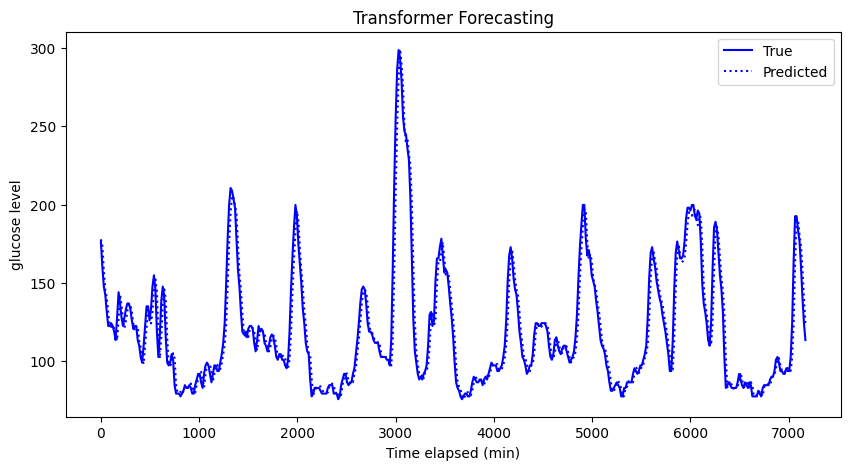

In [ ]:
# def draw(true, pred, index, color):
#     true = true.detach().cpu().numpy()  # Detach the tensor from the computation graph, move it to cpu and convert to numpy array
#     pred = pred.detach().cpu().numpy()  # Detach the tensor from the computation graph, move it to cpu and convert to numpy array

#     plt.figure(figsize=(10, 5))
#     plt.title(f"Transformer Forecasting")
#     plt.xlabel("Time elapsed (min)")
#     plt.ylabel("Glucose mg/dL")
#     n = true.shape[0]
#     plt.plot(np.arange(n*15), true[:, index], label="True")
#     plt.plot(np.arange(n*15), pred[:, index], ":", label="Predicted")
#     plt.legend()
#     plt.show()

# print(test_target.shape)
# print(test_output.shape)

# draw(test_target, test_output, 0, 'r')


def draw(true, pred, index, color):
    true = true.detach().cpu().numpy()  # Detach the tensor from the computation graph, move it to cpu and convert to numpy array
    pred = pred.detach().cpu().numpy()  # Detach the tensor from the computation graph, move it to cpu and convert to numpy array

    plt.figure(figsize=(10, 5))
    plt.title(f"Transformer Forecasting")
    plt.xlabel("Time elapsed (min)")
    plt.ylabel("glucose level")
    n = true.shape[0]
    plt.plot(np.arange(n)*15, true[:, index], color, label="True")
    plt.plot(np.arange(n)*15, pred[:, index], color + ":", label="Predicted")
    plt.legend()
    plt.show()

print(test_target.shape)
print(test_output.shape)

draw(test_target, test_output, 0, 'b')

**Graph 2 Variable Time Horizon**

In [ ]:
final_test_losses = []

prediction_horizons = range(1, 9)

for prediction_horizon in prediction_horizons:
  print(f'Prediction Horizon: {prediction_horizon}\n')
  train_input, train_target, test_input, test_target = train_test_split(df, training_patients, prediction_horizon, device)
  print(train_input.shape)
  print(train_target.shape)
  print(test_input.shape)
  print(test_target.shape)

  # Initialize the model
  model = TransformerModel(embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NLAYERS, dim_feedforward=NHID).to(device)
  criterion = MeanAbsolutePercentageError().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)

  train_losses = []
  test_losses = []
  avg_test_losses = []


  for epoch in tqdm(range(N_EPOCHS)):
      model.train()
      for t in range(0, train_input.shape[0]):
          for patient in range(training_patients):# Loop over the time steps in each epoch
              optimizer.zero_grad()
              output = model(train_input[:t+1,patient,:])
              if len(output.shape) < 3:
                  output = output.unsqueeze(0)
              loss = criterion(output, train_target[:t+1,patient,:].unsqueeze(2))
              loss.backward()
              optimizer.step()
      train_losses.append(loss.item())

      if epoch % 10 == 0:
          print(f'At epoch {epoch}, Training Loss {loss.item()}')


      model.eval()

      with torch.no_grad():
          test_losses = []  # Collect test losses at each time step
          for t in range(0, test_input.shape[0]):
              test_output = model(test_input[:t+1,:,:])
              test_loss = criterion(test_output, test_target[:t+1,:,:])
              test_losses.append(test_loss.item())
          avg_test_loss = np.mean(test_losses)
          avg_test_losses.append(avg_test_loss)

      if epoch % 10 == 0:
          print(f'Test Loss at epoch {epoch} is {avg_test_loss}')
  final_test_losses.append(avg_test_losses[-1])

Prediction Horizon: 1

torch.Size([479, 90, 1])
torch.Size([479, 90, 1])
torch.Size([479, 6, 1])
torch.Size([479, 6, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.0691264346241951


  5%|▌         | 1/20 [04:12<1:19:55, 252.41s/it]

Test Loss at epoch 0 is 0.05533827036339206


 50%|█████     | 10/20 [41:26<41:19, 247.97s/it]

At epoch 10, Training Loss 0.06781276315450668


 55%|█████▌    | 11/20 [45:33<37:09, 247.70s/it]

Test Loss at epoch 10 is 0.06022575108766058


100%|██████████| 20/20 [1:22:36<00:00, 247.82s/it]


Prediction Horizon: 2

torch.Size([478, 90, 1])
torch.Size([478, 90, 1])
torch.Size([478, 6, 1])
torch.Size([478, 6, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.17790476977825165


  5%|▌         | 1/20 [04:01<1:16:22, 241.21s/it]

Test Loss at epoch 0 is 0.20591093839835922


 50%|█████     | 10/20 [40:04<40:06, 240.62s/it]

At epoch 10, Training Loss 0.12069976329803467


 55%|█████▌    | 11/20 [44:06<36:09, 241.09s/it]

Test Loss at epoch 10 is 0.09678586446154068


100%|██████████| 20/20 [1:20:35<00:00, 241.75s/it]


Prediction Horizon: 3

torch.Size([477, 90, 1])
torch.Size([477, 90, 1])
torch.Size([477, 6, 1])
torch.Size([477, 6, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.1606065183877945


  5%|▌         | 1/20 [04:00<1:16:08, 240.42s/it]

Test Loss at epoch 0 is 0.137310420129784


 50%|█████     | 10/20 [40:29<40:38, 243.90s/it]

At epoch 10, Training Loss 0.15351836383342743


 55%|█████▌    | 11/20 [44:30<36:26, 242.90s/it]

Test Loss at epoch 10 is 0.12417537884579764


100%|██████████| 20/20 [1:22:52<00:00, 248.64s/it]


Prediction Horizon: 4

torch.Size([476, 90, 1])
torch.Size([476, 90, 1])
torch.Size([476, 6, 1])
torch.Size([476, 6, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.20848427712917328


  5%|▌         | 1/20 [04:16<1:21:11, 256.37s/it]

Test Loss at epoch 0 is 0.22701113555236024


 50%|█████     | 10/20 [41:24<40:52, 245.20s/it]

At epoch 10, Training Loss 0.22944527864456177


 55%|█████▌    | 11/20 [45:26<36:38, 244.26s/it]

Test Loss at epoch 10 is 0.22672514000735364


100%|██████████| 20/20 [1:21:53<00:00, 245.67s/it]


Prediction Horizon: 5

torch.Size([475, 90, 1])
torch.Size([475, 90, 1])
torch.Size([475, 6, 1])
torch.Size([475, 6, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.20389537513256073


  5%|▌         | 1/20 [03:59<1:15:55, 239.76s/it]

Test Loss at epoch 0 is 0.16144604187262684


 50%|█████     | 10/20 [40:49<40:44, 244.46s/it]

At epoch 10, Training Loss 0.20683448016643524


 55%|█████▌    | 11/20 [44:52<36:37, 244.19s/it]

Test Loss at epoch 10 is 0.15975346668770438


100%|██████████| 20/20 [1:21:28<00:00, 244.42s/it]


Prediction Horizon: 6

torch.Size([474, 90, 1])
torch.Size([474, 90, 1])
torch.Size([474, 6, 1])
torch.Size([474, 6, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.217023566365242


  5%|▌         | 1/20 [04:04<1:17:33, 244.91s/it]

Test Loss at epoch 0 is 0.18072689931352431


 50%|█████     | 10/20 [41:00<40:46, 244.62s/it]

At epoch 10, Training Loss 0.21986503899097443


 55%|█████▌    | 11/20 [45:01<36:32, 243.66s/it]

Test Loss at epoch 10 is 0.17516913315289132


100%|██████████| 20/20 [1:21:32<00:00, 244.62s/it]


Prediction Horizon: 7

torch.Size([473, 90, 1])
torch.Size([473, 90, 1])
torch.Size([473, 6, 1])
torch.Size([473, 6, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.24344012141227722


  5%|▌         | 1/20 [04:07<1:18:30, 247.90s/it]

Test Loss at epoch 0 is 0.2707927166533521


 50%|█████     | 10/20 [40:41<40:35, 243.59s/it]

At epoch 10, Training Loss 0.22776900231838226


 55%|█████▌    | 11/20 [44:43<36:28, 243.16s/it]

Test Loss at epoch 10 is 0.20670666440092736


100%|██████████| 20/20 [1:21:39<00:00, 245.00s/it]


Prediction Horizon: 8

torch.Size([472, 90, 1])
torch.Size([472, 90, 1])
torch.Size([472, 6, 1])
torch.Size([472, 6, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.27971598505973816


  5%|▌         | 1/20 [04:12<1:19:50, 252.11s/it]

Test Loss at epoch 0 is 0.27359557492753206


 50%|█████     | 10/20 [41:14<40:47, 244.74s/it]

At epoch 10, Training Loss 0.23484216630458832


 55%|█████▌    | 11/20 [45:17<36:37, 244.15s/it]

Test Loss at epoch 10 is 0.20385817754066596


100%|██████████| 20/20 [1:22:11<00:00, 246.56s/it]


In [ ]:
final_test_losses

[0.05450725907728169,
 0.09783832851999973,
 0.12412750263321574,
 0.1923755243295381,
 0.16239501968810433,
 0.17350894259878352,
 0.21618168626224768,
 0.22463695742821288]

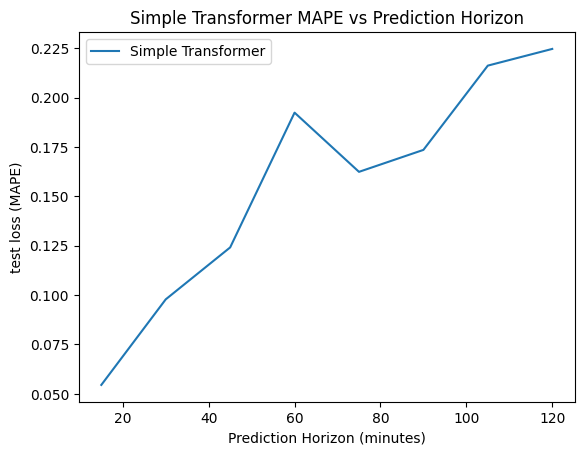

In [ ]:
# Training Curve
plt.figure()
plt.plot([15*x for x in prediction_horizons],final_test_losses, label = "Transformer")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Prediction Horizon (minutes)")
plt.title("Transformer MAPE vs Prediction Horizon")
plt.legend()
plt.show()

Graph 3 Variable Training Patients

In [ ]:
training_patients_sizes = [1,10,20,30,40,50,60,70,80,90]

final_test_losses = []
prediction_horizon = 3


for training_patients in training_patients_sizes:
  train_input, train_target, test_input, test_target = train_test_split(df, training_patients, prediction_horizon, device)
  print(train_input.shape)
  print(train_target.shape)
  print(test_input.shape)
  print(test_target.shape)

  # Initialize the model
  model = TransformerModel(embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NLAYERS, dim_feedforward=NHID).to(device)
  criterion = MeanAbsolutePercentageError().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)

  train_losses = []
  test_losses = []
  avg_test_losses = []


  for epoch in tqdm(range(N_EPOCHS)):
      model.train()
      for t in range(0, train_input.shape[0]):
          for patient in range(training_patients):# Loop over the time steps in each epoch
              optimizer.zero_grad()
              output = model(train_input[:t+1,patient,:])
              if len(output.shape) < 3:
                  output = output.unsqueeze(0)
              loss = criterion(output, train_target[:t+1,patient,:].unsqueeze(2))
              loss.backward()
              optimizer.step()
      train_losses.append(loss.item())

      if epoch % 10 == 0:
          print(f'At epoch {epoch}, Training Loss {loss.item()}')


      model.eval()

      with torch.no_grad():
          test_losses = []  # Collect test losses at each time step
          for t in range(0, test_input.shape[0]):
              test_output = model(test_input[:t+1,:,:])
              test_loss = criterion(test_output, test_target[:t+1,:,:])
              test_losses.append(test_loss.item())
          avg_test_loss = np.mean(test_losses)
          avg_test_losses.append(avg_test_loss)

      if epoch % 10 == 0:
          print(f'Test Loss at epoch {epoch} is {avg_test_loss}')
  final_test_losses.append(avg_test_losses[-1])

torch.Size([477, 1, 1])
torch.Size([477, 1, 1])
torch.Size([477, 95, 1])
torch.Size([477, 95, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.1809181123971939


  5%|▌         | 1/20 [00:03<01:12,  3.80s/it]

Test Loss at epoch 0 is 0.2890961960551624


 50%|█████     | 10/20 [00:52<00:53,  5.40s/it]

At epoch 10, Training Loss 0.11656385660171509


 55%|█████▌    | 11/20 [00:57<00:48,  5.41s/it]

Test Loss at epoch 10 is 0.30319776243883606


100%|██████████| 20/20 [01:46<00:00,  5.33s/it]


torch.Size([477, 10, 1])
torch.Size([477, 10, 1])
torch.Size([477, 86, 1])
torch.Size([477, 86, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.12732158601284027


  5%|▌         | 1/20 [00:29<09:26, 29.81s/it]

Test Loss at epoch 0 is 0.16971379899628758


 50%|█████     | 10/20 [04:59<04:59, 29.90s/it]

At epoch 10, Training Loss 0.11890427023172379


 55%|█████▌    | 11/20 [05:29<04:29, 29.92s/it]

Test Loss at epoch 10 is 0.1472607393684627


100%|██████████| 20/20 [09:58<00:00, 29.91s/it]


torch.Size([477, 20, 1])
torch.Size([477, 20, 1])
torch.Size([477, 76, 1])
torch.Size([477, 76, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.1358174830675125


  5%|▌         | 1/20 [00:56<18:00, 56.85s/it]

Test Loss at epoch 0 is 0.16610045799794187


 50%|█████     | 10/20 [09:30<09:28, 56.89s/it]

At epoch 10, Training Loss 0.12935739755630493


 55%|█████▌    | 11/20 [10:26<08:31, 56.84s/it]

Test Loss at epoch 10 is 0.14155601577313942


100%|██████████| 20/20 [18:56<00:00, 56.85s/it]


torch.Size([477, 30, 1])
torch.Size([477, 30, 1])
torch.Size([477, 66, 1])
torch.Size([477, 66, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.10729730874300003


  5%|▌         | 1/20 [01:23<26:25, 83.43s/it]

Test Loss at epoch 0 is 0.16071447939367914


 50%|█████     | 10/20 [13:54<13:55, 83.56s/it]

At epoch 10, Training Loss 0.09259320795536041


 55%|█████▌    | 11/20 [15:17<12:30, 83.34s/it]

Test Loss at epoch 10 is 0.13430410473601623


100%|██████████| 20/20 [27:46<00:00, 83.31s/it]


torch.Size([477, 40, 1])
torch.Size([477, 40, 1])
torch.Size([477, 56, 1])
torch.Size([477, 56, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.16066765785217285


  5%|▌         | 1/20 [01:49<34:42, 109.58s/it]

Test Loss at epoch 0 is 0.14420778099720832


 50%|█████     | 10/20 [18:20<18:21, 110.17s/it]

At epoch 10, Training Loss 0.16023403406143188


 55%|█████▌    | 11/20 [20:10<16:31, 110.17s/it]

Test Loss at epoch 10 is 0.1332566513361671


100%|██████████| 20/20 [36:41<00:00, 110.08s/it]


torch.Size([477, 50, 1])
torch.Size([477, 50, 1])
torch.Size([477, 46, 1])
torch.Size([477, 46, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.12282729893922806


  5%|▌         | 1/20 [02:16<43:13, 136.48s/it]

Test Loss at epoch 0 is 0.15362726514319452


 50%|█████     | 10/20 [22:52<22:54, 137.42s/it]

At epoch 10, Training Loss 0.12797711789608002


 55%|█████▌    | 11/20 [25:10<20:36, 137.35s/it]

Test Loss at epoch 10 is 0.14124653877327278


100%|██████████| 20/20 [45:36<00:00, 136.83s/it]


torch.Size([477, 60, 1])
torch.Size([477, 60, 1])
torch.Size([477, 36, 1])
torch.Size([477, 36, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.14280590415000916


  5%|▌         | 1/20 [02:43<51:42, 163.29s/it]

Test Loss at epoch 0 is 0.13566820089172268


 50%|█████     | 10/20 [27:17<27:20, 164.01s/it]

At epoch 10, Training Loss 0.14399230480194092


 55%|█████▌    | 11/20 [30:02<24:36, 164.07s/it]

Test Loss at epoch 10 is 0.12387574985779556


100%|██████████| 20/20 [55:22<00:00, 166.10s/it]


torch.Size([477, 70, 1])
torch.Size([477, 70, 1])
torch.Size([477, 26, 1])
torch.Size([477, 26, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.10903153568506241


  5%|▌         | 1/20 [03:17<1:02:35, 197.65s/it]

Test Loss at epoch 0 is 0.12690145897228014


 50%|█████     | 10/20 [32:48<32:46, 196.67s/it]

At epoch 10, Training Loss 0.10401029139757156


 55%|█████▌    | 11/20 [36:08<29:40, 197.86s/it]

Test Loss at epoch 10 is 0.12457934684223598


100%|██████████| 20/20 [1:05:49<00:00, 197.50s/it]


torch.Size([477, 80, 1])
torch.Size([477, 80, 1])
torch.Size([477, 16, 1])
torch.Size([477, 16, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.09342468529939651


  5%|▌         | 1/20 [03:45<1:11:23, 225.44s/it]

Test Loss at epoch 0 is 0.14686404505990586


 50%|█████     | 10/20 [37:45<37:48, 226.89s/it]

At epoch 10, Training Loss 0.08590568602085114


 55%|█████▌    | 11/20 [41:31<33:59, 226.62s/it]

Test Loss at epoch 10 is 0.12643573865825525


100%|██████████| 20/20 [1:15:48<00:00, 227.42s/it]


torch.Size([477, 90, 1])
torch.Size([477, 90, 1])
torch.Size([477, 6, 1])
torch.Size([477, 6, 1])


  0%|          | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.1542309820652008


  5%|▌         | 1/20 [04:13<1:20:17, 253.58s/it]

Test Loss at epoch 0 is 0.1255960100695522


 50%|█████     | 10/20 [42:36<42:33, 255.34s/it]

At epoch 10, Training Loss 0.15356607735157013


 55%|█████▌    | 11/20 [46:51<38:16, 255.12s/it]

Test Loss at epoch 10 is 0.12259121439117056


100%|██████████| 20/20 [1:25:17<00:00, 255.86s/it]


In [ ]:
final_test_losses

[0.29672742383535056,
 0.1518670172124039,
 0.1383827210284879,
 0.13770572880216614,
 0.12854232693743156,
 0.1384688645163922,
 0.1246102333568677,
 0.1276592392654039,
 0.12569861554499692,
 0.12364523973417482]

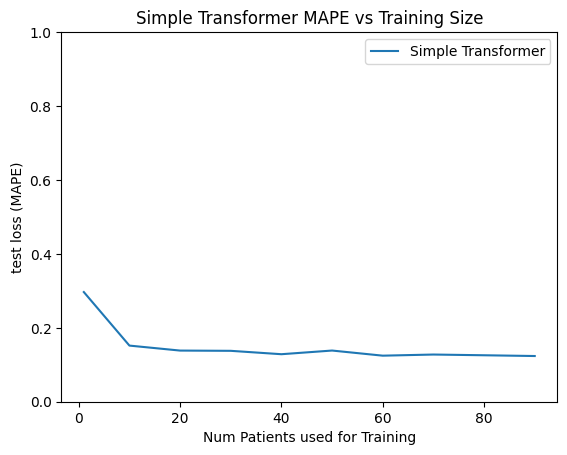

In [ ]:
#Training Curve
plt.figure()
plt.plot(training_patients_sizes,final_test_losses, label = "Transformer")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Num Patients used for Training")
plt.title("Simple Transformer MAPE vs Training Size")
plt.ylim(0,1)
plt.legend()
plt.show()